In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os.path
import biophysnn
import motifscanner
import bindingdata

import scipy.stats
import seaborn as sns

from importlib import reload

pwm_source = "K562"
RBP = "RBFOX2"
rep = "rep2" # rep1 for A1, rep2 for RBFOX2, can be "both" for HNRNPK

/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IP_col = RBP.lower() + "-" + rep
input_col = "input-" + rep

dat_file = "/gpfs/commons/home/mschertzer/asb_model/220708_all_ipsc_ip/enrichment_values/all_data_gencode_v41_300w_100s.txt.gz"
dat = pd.read_csv(dat_file, sep = "\t")
dat.rename(columns={"X1":"chrom","X2":"start","X3":"end","X4":"gene","X6":"strand"}, inplace=True)
dat

,chrom,start,end,gene,X5,strand,CW30154-hnrnpk,CW30154-input,hnrnpa1-rep1,hnrnpk-rep1,hnrnpk-rep2,input-rep1,input-rep2,rbfox2-rep2
0,chr1,65419,65719,ENSG00000186092.7,.,+,0,0,0,0,0,0,0,0
1,chr1,65519,65819,ENSG00000186092.7,.,+,0,0,0,0,0,0,0,0
2,chr1,65619,65919,ENSG00000186092.7,.,+,0,0,0,0,0,0,0,0
3,chr1,65719,66019,ENSG00000186092.7,.,+,0,0,0,0,0,0,0,0
4,chr1,65819,66119,ENSG00000186092.7,.,+,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13800279,chrM,15447,15747,ENSG00000198727.2,.,+,78292,10783,37243,685023,583759,100210,116039,28846
13800280,chrM,15547,15847,ENSG00000198727.2,.,+,69660,9659,29247,608916,541008,92383,107683,24885
13800281,chrM,15647,15887,ENSG00000198727.2,.,+,64675,9019,23412,567753,514752,86913,101927,22927
13800282,chrM,15747,15887,ENSG00000198727.2,.,+,29685,6007,13815,276546,309839,57881,67280,14521


In [3]:
dat["hnrnpk-both"] = dat["hnrnpk-rep1"] + dat["hnrnpk-rep2"]
dat["input-both"] = dat["input-rep1"] + dat["input-rep2"]

In [4]:
dat.iloc[:,-8:].sum(0)

hnrnpa1-rep1    1191470049
hnrnpk-rep1     1299814470
hnrnpk-rep2      877928296
input-rep1      1363084884
input-rep2      1359492001
rbfox2-rep2     1148823603
hnrnpk-both     2177742766
input-both      2722576885
dtype: int64

In [5]:
total_count_threshold = 30
dat_sub = dat[dat.loc[:,[IP_col,input_col]].sum(1) > total_count_threshold]

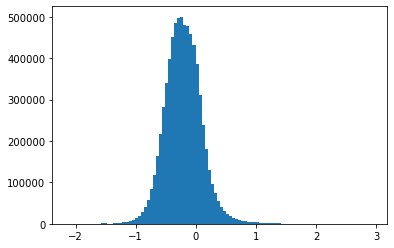

In [6]:
enrich = dat_sub[IP_col] / (dat_sub[input_col] + 1.)
_ = plt.hist(np.log10(enrich[enrich>0]), bins = 100)

In [7]:
(enrich > 3.).mean()

0.018809384418389804

In [8]:
genome = pickle.load(open("/gpfs/commons/home/daknowles/knowles_lab/index/hg38/hg38.pkl","rb")) # this is here in case there's hg38 data you want to analyse

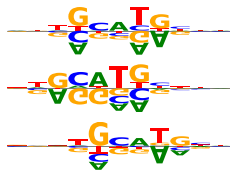

In [9]:
if pwm_source == "oRNAment":
    pwm_dat = np.load("/gpfs/commons/home/daknowles/apex_seq/pwms.npz")
    pwm_names = pwm_dat['names']
    pwms = pwm_dat['pwms']

    pwms[pwms > 0].min()
    log_pwms = np.log(pwms + 1e-4)

    # Convert to actual PWM
    w = torch.tensor(log_pwms, dtype=torch.float).transpose(0,2)
    w_norm = w - w.mean(1,keepdims=True)

    specific_pwms = w_norm[ np.array([ RBP in g for g in pwm_names ]) ]
    specific_pwms.shape
else: 
    base_dir = "/gpfs/commons/groups/knowles_lab/data/oRNAment/mCross/"
    pwm = np.load(base_dir + "mCross_pwm.npy")
    meta = pd.read_csv(base_dir + "pwm_meta.tsv", sep = "\t")
    #specific_motifs = (meta.RBP == RBP) & (meta.Celltype == "HepG2").to_numpy()
    
    specific_motifs = (meta.RBP == RBP) & (meta.Celltype == pwm_source).to_numpy()
    specific_pwms = torch.tensor(pwm[specific_motifs,:,:], dtype = torch.float)
    specific_pwms -= specific_pwms.mean(1, keepdims=True)

biophysnn.plot_motifs(specific_pwms)

In [10]:
bind_all = dat_sub.rename(columns={IP_col : "IP_counts", input_col : "input_counts" })
bind_all

,chrom,start,end,gene,X5,strand,CW30154-hnrnpk,CW30154-input,hnrnpa1-rep1,hnrnpk-rep1,hnrnpk-rep2,input-rep1,input_counts,IP_counts,hnrnpk-both,input-both
285,chr1,944203,944503,ENSG00000188976.11,.,-,55,218,982,432,283,1868,1533,1749,715,3401
287,chr1,944303,944603,ENSG00000188976.11,.,-,53,299,1483,532,326,2529,2178,2342,858,4707
289,chr1,944403,944703,ENSG00000188976.11,.,-,46,257,1460,494,283,2275,1982,2154,777,4257
291,chr1,944503,944803,ENSG00000188976.11,.,-,39,189,1174,384,212,1672,1564,1580,596,3236
293,chr1,944603,944903,ENSG00000188976.11,.,-,24,149,917,308,154,1194,1176,1120,462,2370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13800279,chrM,15447,15747,ENSG00000198727.2,.,+,78292,10783,37243,685023,583759,100210,116039,28846,1268782,216249
13800280,chrM,15547,15847,ENSG00000198727.2,.,+,69660,9659,29247,608916,541008,92383,107683,24885,1149924,200066
13800281,chrM,15647,15887,ENSG00000198727.2,.,+,64675,9019,23412,567753,514752,86913,101927,22927,1082505,188840
13800282,chrM,15747,15887,ENSG00000198727.2,.,+,29685,6007,13815,276546,309839,57881,67280,14521,586385,125161


In [11]:
test_chromosomes = ["chr1"]
test_data = bind_all[ bind_all['chrom'].isin( test_chromosomes ) ]

validation_chromosomes = ["chr2","chr3"]
validation_data = bind_all[ bind_all['chrom'].isin(validation_chromosomes) ]

train_chromosomes = ["chr%i" % i for i in range(4, 22+1)]
train_data = bind_all[ bind_all['chrom'].isin( train_chromosomes ) ]

test_data.shape[0] / bind_all.shape[0], validation_data.shape[0] / bind_all.shape[0]

(0.09032076246122235, 0.1527853798850037)

In [12]:

phys_net = motifscanner.PhysNet(specific_pwms, 
                                max_over_positions = False, 
                                max_over_motifs = False, 
                                seq_len = 300)
check_point_filename = "predict_enrich_checkpoints/%s_%s.pt" % (RBP, pwm_source)

if os.path.isfile(check_point_filename): 
    phys_net.load_state_dict(torch.load(check_point_filename)) 
else: 
    train_metrics, val_metrics =  biophysnn.train_model(
       phys_net,
       train_data, 
       validation_data, 
       genome, 
       num_workers = 8,
       regression = True,
       verbose = True, 
       check_point_filename = check_point_filename,
       lr = 0.1)

In [13]:
{ k:v for k,v in phys_net.named_parameters() }

{'motif_scale_unc': Parameter containing:
 tensor([1., 1., 1.], requires_grad=True),
 'motif_offset': Parameter containing:
 tensor([0., 0., 0.], requires_grad=True),
 'scale_unc': Parameter containing:
 tensor(1., requires_grad=True),
 'offset': Parameter containing:
 tensor(0., requires_grad=True)}

In [14]:
val_metrics, preds, labels, enrichs  = biophysnn.eval_model(phys_net, validation_data, genome, regression = True)

In [15]:
enrichs

array([0.78571427, 0.75233644, 0.9162996 , ..., 0.7419355 , 0.75      ,
       0.6097561 ], dtype=float32)

In [16]:
scipy.stats.pearsonr(np.exp(preds), enrichs)

(0.12994627326977878, 0.0)

In [17]:
pd.DataFrame(val_metrics._asdict(), index=[0]).to_csv(
    "predict_enrich_notebooks/metrics_%s_%s.tsv" % (RBP, pwm_source), sep = "\t", index = False)

Text(0, 0.5, 'Observed enrichment')

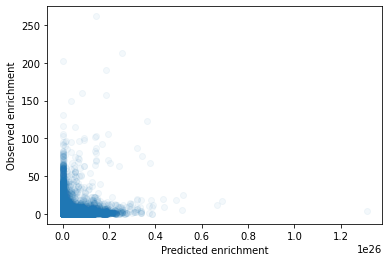

In [18]:
plt.scatter(np.exp(preds), enrichs, alpha=0.05)
plt.xlabel("Predicted enrichment")
plt.ylabel("Observed enrichment")

In [19]:
#sns.kdeplot(np.exp(preds), enrichs)
#plt.xlabel("Predicted enrichment")
#plt.ylabel("Observed enrichment")

<ipython-input-20-3515f55d9f21>:1: RuntimeWarning: divide by zero encountered in log2
  plt.scatter(np.log2(np.exp(preds)), np.log2(enrichs), color = "black", alpha=0.005) # separate by gene regions


Text(0, 0.5, 'log2 Observed enrichment')

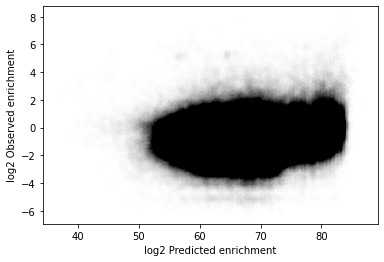

In [20]:
plt.scatter(np.log2(np.exp(preds)), np.log2(enrichs), color = "black", alpha=0.005) # separate by gene regions
plt.xlabel("log2 Predicted enrichment")
plt.ylabel("log2 Observed enrichment")

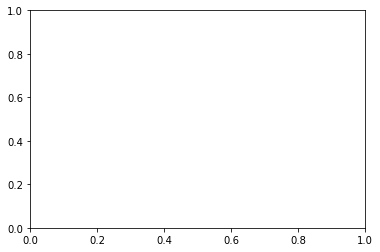

In [21]:
try: 
    sns.kdeplot(preds, np.log(enrichs + 0.01))
    plt.xlabel("Predicted enrichment")
    plt.ylabel("Observed enrichment")
except: 
    pass

## How well do we do on predicting peaks? 

In [25]:
rep = "_rep2"
basedir = "/gpfs/commons/home/mschertzer/asb_model/220708_all_ipsc_ip/alignments/macs/"
peak_file = basedir + ("all_%s%s_stranded_noigg.narrowPeak" % (RBP.lower(), rep))
binding_data = pd.read_csv(peak_file, sep='\t', usecols=range(6), names=("chrom","start","end","name","score","strand"))
binding_data = binding_data[ ~binding_data['chrom'].isin(["chrX","chrY"]) ] # only keep autosomes (non sex chromosomes)
binding_data = binding_data.sort_values(['chrom', 'start']).drop_duplicates() # sort so we can interleave negatives

unbound = pd.read_csv("/gpfs/commons/home/daknowles/pooledRBPs/biophysical_cnn/unbound_regions/%s_unbound.bed.gz" % RBP, 
              sep = "\t", 
              names = ["chrom", "start", "end", "name", "strand", "counts", "length"],
              index_col = False)

unbound["score"] = 0
bind_all = pd.concat([binding_data,
           unbound.loc[:, ~unbound.columns.isin(['counts', 'length'])]], 
          axis=0)

test_chromosomes = ["chr1"]
test_data = bind_all[ bind_all['chrom'].isin( test_chromosomes ) ]

validation_chromosomes = ["chr2","chr3"]
validation_data = bind_all[ bind_all['chrom'].isin(validation_chromosomes) ]

train_chromosomes = ["chr%i" % i for i in range(4, 22+1)]
train_data = bind_all[ bind_all['chrom'].isin( train_chromosomes ) ]


/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [29]:
val_metrics, _, _, _ = biophysnn.eval_model(phys_net, validation_data, genome, regression = False)
val_metrics

EpochMetrics(loss=24.034588, acc=0.5017497812773404, auroc=0.6264570327180957, aupr=0.6583464202978083)